# Set up

In [34]:
pip install datasets


Note: you may need to restart the kernel to use updated packages.


In [35]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [36]:
import warnings
warnings.filterwarnings("ignore")
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pytz
from wordcloud import WordCloud


from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import NearestNeighbors

# Get data

In [37]:
#Dataset from Huggingface
ds = load_dataset("VictorHu0602/spotifymusic_73countries")

In [ ]:

#Get my streaming data
streaming_data1 = "Spotify Extended Streaming History/Streaming_History_Audio_2023-2024_1.json"  
streaming_data2= "Spotify Extended Streaming History/Streaming_History_Audio_2024-2025_2.json"  
df1 = pd.read_json(streaming_data1)
df2 = pd.read_json(streaming_data2)

df = pd.concat([df1, df2], ignore_index=True)

df['track_id'] = df['spotify_track_uri'].apply(lambda x: x.split(':')[-1] if x is not None else 'N/A')
df.head()

,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,...,audiobook_chapter_uri,audiobook_chapter_title,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode,track_id
0,2023-10-18T11:28:28Z,osx,234146,VN,101.53.45.69,Miss Americana & The Heartbreak Prince,Taylor Swift,Lover,spotify:track:214nt20w5wOxJnY462klLw,None,...,NaN,NaN,trackdone,trackdone,False,False,False,1697628274,False,214nt20w5wOxJnY462klLw
1,2023-10-18T11:31:26Z,osx,178426,VN,101.53.45.69,Cruel Summer,Taylor Swift,Lover,spotify:track:1BxfuPKGuaTgP7aM0Bbdwr,None,...,NaN,NaN,trackdone,trackdone,False,False,False,1697628508,False,1BxfuPKGuaTgP7aM0Bbdwr
2,2023-10-18T11:34:37Z,osx,190360,VN,101.53.45.69,The Man,Taylor Swift,Lover,spotify:track:3RauEVgRgj1IuWdJ9fDs70,None,...,NaN,NaN,trackdone,trackdone,False,False,False,1697628687,False,3RauEVgRgj1IuWdJ9fDs70
3,2023-10-18T11:37:29Z,osx,171360,VN,101.53.45.69,You Need To Calm Down,Taylor Swift,Lover,spotify:track:6RRNNciQGZEXnqk8SQ9yv5,None,...,NaN,NaN,trackdone,trackdone,False,False,False,1697628878,False,6RRNNciQGZEXnqk8SQ9yv5
4,2023-10-18T11:41:53Z,osx,221306,VN,101.53.45.69,Lover,Taylor Swift,Lover,spotify:track:1dGr1c8CrMLDpV6mPbImSI,None,...,NaN,NaN,trackdone,trackdone,False,False,False,1697629050,False,1dGr1c8CrMLDpV6mPbImSI


In [39]:
# Convert timestamp column to Vietnam timezone (Asia/Ho_Chi_Minh)
# Then filter only 2024 data

df['ts'] = pd.to_datetime(df['ts'], utc=True)
df['ts_vn'] = df['ts'].dt.tz_convert('Asia/Ho_Chi_Minh')

df = df[(df['ts_vn'] >= '2024-01-01') & (df['ts_vn'] < '2025-01-01')]

In [40]:
df.isna().sum()

ts                                       0
platform                                 0
ms_played                                0
conn_country                             0
ip_addr                                  0
master_metadata_track_name              64
master_metadata_album_artist_name       64
master_metadata_album_album_name        64
spotify_track_uri                       64
episode_name                         13759
episode_show_name                    13759
spotify_episode_uri                  13759
audiobook_title                      13823
audiobook_uri                        13823
audiobook_chapter_uri                13823
audiobook_chapter_title              13823
reason_start                             0
reason_end                               0
shuffle                                  0
skipped                                  0
offline                                  0
offline_timestamp                        0
incognito_mode                           0
track_id   

This project focuses on music streaming and recommendation, so I will remove podcast and audio book data. I will also drop these columns from the table.

In [41]:
df=df[~df['master_metadata_track_name'].isna()]
df=df[df['episode_name'].isna()]


df = df.drop(columns=['ip_addr','spotify_track_uri', 'episode_name',
       'episode_show_name', 'spotify_episode_uri','audiobook_title',
       'audiobook_uri', 'audiobook_chapter_uri', 'audiobook_chapter_title','incognito_mode'])

In [42]:
df.isna().sum()

ts                                   0
platform                             0
ms_played                            0
conn_country                         0
master_metadata_track_name           0
master_metadata_album_artist_name    0
master_metadata_album_album_name     0
reason_start                         0
reason_end                           0
shuffle                              0
skipped                              0
offline                              0
offline_timestamp                    0
track_id                             0
ts_vn                                0
dtype: int64

In [43]:
df.shape

(13759, 15)

In [ ]:
track_data1 = "Track Data/high_popularity_spotify_data.csv"
track_data2 = "Track Data/low_popularity_spotify_data.csv"
track_data3 = "Track Data/spotify_tracks.csv"
track_data4 = "Track Data/taylor_swift_spotify.csv"


track1 = pd.read_csv(track_data1)
track2 = pd.read_csv(track_data2)
track3 = pd.read_csv(track_data3)
track4 = pd.read_csv(track_data4)
track5 = ds["train"].to_pandas()


track1['track_id'] = track1['id']
track2['track_id'] = track2['id']
track4['track_id'] = track4['id']
track5['track_id'] = track5['spotify_id']

track4['track_name'] = track4['name']
track5['track_name'] = track5['name']
track3['track_artist'] = track3['artist_name']
track4['track_artist'] = 'Taylor Swift'
track5['track_artist'] = track5['artists']

track1['popularity'] = track1['track_popularity']
track2['popularity'] = track2['track_popularity']

common_cols = ['track_id','track_name','track_artist','danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','popularity']

track1 = track1[common_cols]
track2 = track2[common_cols]
track3 = track3[common_cols]
track4 = track4[common_cols]
track5 = track5[common_cols]

df_track = pd.concat([track1, track2,track4,track5], ignore_index=True).drop_duplicates(subset='track_id', keep='last')
df_track

,track_id,track_name,track_artist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity
3,1d7Ptw3qYcfpdLNL5REhtJ,Taste,Sabrina Carpenter,0.670,0.910,-4.070,0.0634,0.09390,0.000000,0.304,0.786,112.966,81
16,5G345YEhvleYxQLfYUlEFv,Moonlit Floor (Kiss Me),LISA,0.734,0.787,-3.951,0.1160,0.12600,0.000000,0.312,0.672,109.939,82
30,4VI2Y5xg4gYynQqNQNQbTN,WHATCHU KNO ABOUT ME (with Sexyy Red),"GloRilla, Sexyy Red",0.836,0.691,-4.222,0.3630,0.00586,0.000000,0.282,0.703,167.029,70
49,3dPQuX8Gs42Y7b454ybpMR,Seven Nation Army,The White Stripes,0.743,0.446,-7.807,0.0683,0.00390,0.118000,0.337,0.278,123.596,82
50,70LcF31zb1H0PyJoS1Sx1r,Creep,Radiohead,0.515,0.430,-9.935,0.0372,0.00970,0.000133,0.129,0.104,91.844,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1733790,0AYt6NMyyLd0rLuvr0UkMH,Slime You Out (feat. SZA),"Drake, SZA",0.483,0.408,-9.243,0.0502,0.50800,0.000000,0.259,0.105,88.880,84
1733791,2Gk6fi0dqt91NKvlzGsmm7,SAY MY GRACE (feat. Travis Scott),"Offset, Travis Scott",0.773,0.635,-5.060,0.0452,0.05850,0.000000,0.132,0.476,121.879,80
1733792,26b3oVLrRUaaybJulow9kz,People,Libianca,0.573,0.422,-7.621,0.0678,0.55100,0.000013,0.102,0.693,124.357,88
1733793,5ydjxBSUIDn26MFzU3asP4,Rainy Days,V,0.633,0.454,-8.016,0.0875,0.73900,0.000000,0.148,0.282,74.828,88


In [45]:
df_track.isna().sum()

track_id            1
track_name          8
track_artist        7
danceability        1
energy              1
loudness            1
speechiness         1
acousticness        1
instrumentalness    1
liveness            1
valence             1
tempo               1
popularity          0
dtype: int64

In [46]:
df_track.dropna(inplace=True)

In [47]:
df_track.shape

(24818, 13)

We successfylly got 2 tables: df (my streaming history) and df_track (list of ~25K music tracks with audio features)

# Streaming Behavior Analysis

In [48]:

# Extract features from local time
df['hour'] = df['ts_vn'].dt.hour
df['date'] = df['ts_vn'].dt.date
df['day_of_week'] = df['ts_vn'].dt.day_name()
df['first_day_of_month'] = df['ts_vn'].dt.to_period('M').dt.to_timestamp()


def get_time_of_day(hour):
    if 6 <= hour < 10:
        return "1.Morning"
    elif 10 <= hour < 15:
        return "2.Midday"
    elif 15 <= hour < 19:
        return "3.Evening"
    elif 19 <= hour < 23:
        return "4.Night"
    else:
        return "5.Midnight"

df['time_of_day'] = df['hour'].apply(get_time_of_day)

In [49]:
df

,ts,platform,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,track_id,ts_vn,hour,date,day_of_week,first_day_of_month,time_of_day
3079,2024-01-01 00:56:19+00:00,ios,212600,VN,Welcome To New York (Taylor's Version),Taylor Swift,1989 (Taylor's Version),trackdone,trackdone,False,False,False,1704024012,1hR8BSuEqPCCZfv93zzzz9,2024-01-01 07:56:19+07:00,7,2024-01-01,Monday,2024-01-01,1.Morning
3080,2024-01-01 01:00:10+00:00,ios,229942,VN,Snow On The Beach (feat. More Lana Del Rey),Taylor Swift,Midnights,trackdone,trackdone,False,False,False,1704070579,4zmKGsrXjLmljb5fTaBTot,2024-01-01 08:00:10+07:00,8,2024-01-01,Monday,2024-01-01,1.Morning
3081,2024-01-01 01:04:08+00:00,ios,238693,VN,Mean (Taylor's Version),Taylor Swift,Speak Now (Taylor's Version),trackdone,trackdone,False,False,False,1704070810,30Y4CV7A6YqtQtTTo7Ue4j,2024-01-01 08:04:08+07:00,8,2024-01-01,Monday,2024-01-01,1.Morning
3082,2024-01-01 01:08:40+00:00,ios,271000,VN,Clean (Taylor's Version),Taylor Swift,1989 (Taylor's Version),trackdone,trackdone,False,False,False,1704071049,2ByBBvpR9b7IynvRmnG7kG,2024-01-01 08:08:40+07:00,8,2024-01-01,Monday,2024-01-01,1.Morning
3083,2024-01-01 01:12:35+00:00,ios,234466,VN,Hits Different,Taylor Swift,Midnights,trackdone,trackdone,False,False,False,1704071320,3xYJScVfxByb61dYHTwiby,2024-01-01 08:12:35+07:00,8,2024-01-01,Monday,2024-01-01,1.Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17743,2024-12-31 11:17:16+00:00,ios,228639,VN,we can't be friends (wait for your love),Ariana Grande,eternal sunshine,trackdone,trackdone,False,False,False,1735643607,51ZQ1vr10ffzbwIjDCwqm4,2024-12-31 18:17:16+07:00,18,2024-12-31,Tuesday,2024-12-01,3.Evening
17744,2024-12-31 11:20:23+00:00,ios,186365,VN,Please Please Please,Sabrina Carpenter,Please Please Please,trackdone,trackdone,False,False,False,1735643836,5N3hjp1WNayUPZrA8kJmJP,2024-12-31 18:20:23+07:00,18,2024-12-31,Tuesday,2024-12-01,3.Evening
17745,2024-12-31 11:24:04+00:00,ios,220839,VN,"Đi Giữa Trời Rực Rỡ - From ""Đi Giữa Trời Rực Rỡ""",Ngô Lan Hương,Đi Giữa Trời Rực Rỡ,trackdone,trackdone,False,False,False,1735644023,62bwj2FZsr0ljcap1FEf8g,2024-12-31 18:24:04+07:00,18,2024-12-31,Tuesday,2024-12-01,3.Evening
17746,2024-12-31 11:26:53+00:00,ios,168358,VN,LIKE THAT,BABYMONSTER,BABYMONS7ER,trackdone,trackdone,False,False,False,1735644244,7GDgpad2BQVuDUzaxHFakc,2024-12-31 18:26:53+07:00,18,2024-12-31,Tuesday,2024-12-01,3.Evening


## Top artists, top songs 

First, I want to see my list of top artist and top songs I listened most frequently.

In [50]:
df_artist_freq = df.groupby("master_metadata_album_artist_name").agg(count=('ts','count')).reset_index().sort_values(by='count',ascending=False).head(50)
df_track_freq = df.groupby(["track_id",'master_metadata_track_name']).agg(count=('ts','count')).reset_index().sort_values(by='count',ascending=False).head(50)

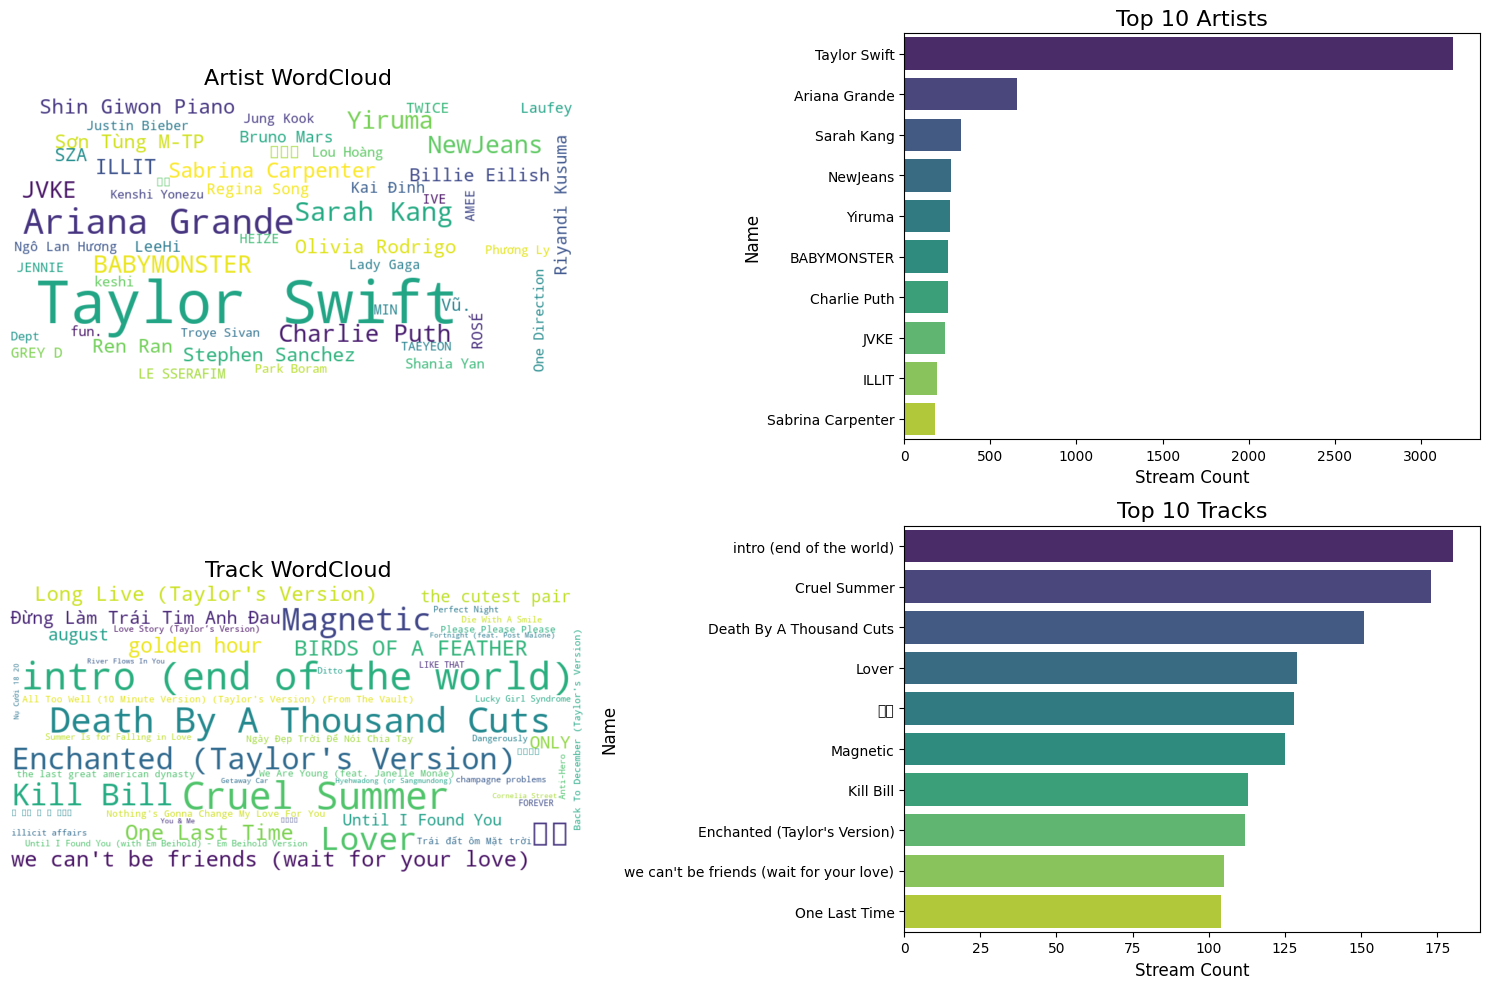

In [51]:
def create_wordcloud_ax(df, keyword, frequency, ax, title):
    word_freq = dict(zip(df[keyword], df[frequency]))
    wordcloud = WordCloud(
        width=800, height=400, background_color='white', colormap='viridis'
    ).generate_from_frequencies(word_freq)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title, fontsize=16)

def create_top_10_ax(df, keyword, frequency, ax, title):
    top10 = df.sort_values(by=frequency, ascending=False).head(10)
    sns.barplot(data=top10, x=frequency, y=keyword, palette="viridis", ax=ax)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Stream Count", fontsize=12)
    ax.set_ylabel("Name", fontsize=12)

# Create 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Row 1: Artist plots
create_wordcloud_ax(df_artist_freq, 'master_metadata_album_artist_name', 'count', axes[0,0], "Artist WordCloud")
create_top_10_ax(df_artist_freq, 'master_metadata_album_artist_name', 'count', axes[0,1], "Top 10 Artists")

# Row 2: Track plots
create_wordcloud_ax(df_track_freq, 'master_metadata_track_name', 'count', axes[1,0], "Track WordCloud")
create_top_10_ax(df_track_freq, 'master_metadata_track_name', 'count', axes[1,1], "Top 10 Tracks")

plt.tight_layout()
plt.show()


Taylor Swift stands out as my most frequent artist in 2024!! (Hiii Swifties!!)



## Streaming frequency by hour and months

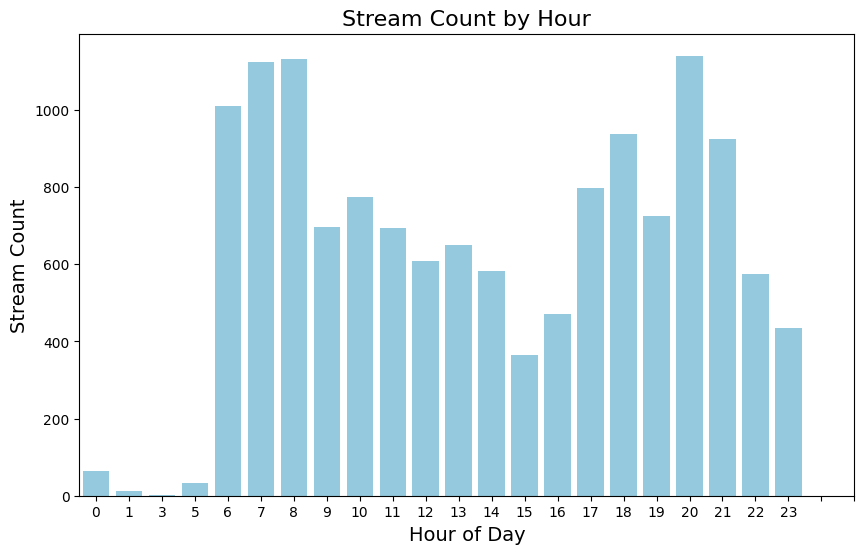

In [52]:
hourly_counts = df.groupby('hour')['ts'].count().reset_index()
hourly_counts.rename(columns={'ts': 'stream_count'}, inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(data=hourly_counts, x='hour', y='stream_count', color='skyblue')

plt.title("Stream Count by Hour", fontsize=16)
plt.xlabel("Hour of Day", fontsize=14)
plt.ylabel("Stream Count", fontsize=14)
plt.xticks(range(0,24))
plt.show()


The bimodal distribution indicates my most active time on spotify is early morning (6-8) and evening (17-21). My most frequent use case in these times is listening to music while workout or to focus at work.

My next question: Is this pattern different between days of the week?

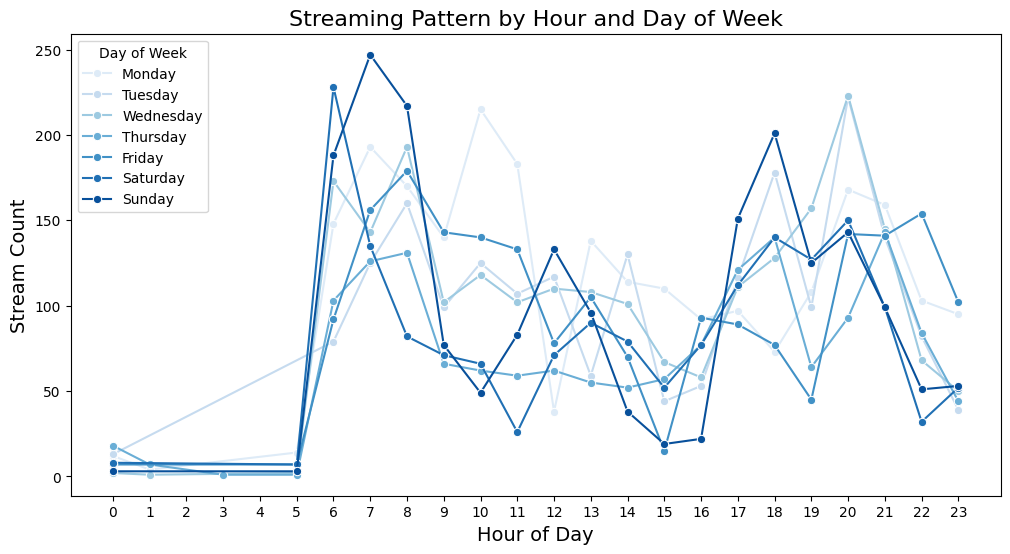

In [53]:

hourly_pattern = (
    df.groupby(['day_of_week', 'hour'])['ts']
      .count()
      .reset_index()
      .rename(columns={'ts': 'stream_count'})
)

# Order days correctly
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hourly_pattern['day_of_week'] = pd.Categorical(hourly_pattern['day_of_week'], categories=days_order, ordered=True)


palette = sns.color_palette("Blues", n_colors=7)  
plt.figure(figsize=(12,6))
sns.lineplot(
    data=hourly_pattern, 
    x='hour', 
    y='stream_count', 
    hue='day_of_week', 
    marker='o',
    palette=palette
)

plt.title("Streaming Pattern by Hour and Day of Week", fontsize=16)
plt.xlabel("Hour of Day", fontsize=14)
plt.ylabel("Stream Count", fontsize=14)
plt.xticks(range(0,24))
plt.legend(title='Day of Week')
plt.show()

My streaming behavior shows clear differences between weekdays and weekends: 
- Weekends:
    - Noticeable peaks in the early morning (6–8 AM) and again around 17–18 PM, which aligns with my running time.

- Weekdays:

    + Lower activity in the early mornings.

    + Increased streaming during 9–11 AM, isn't it my deep work sessions?

    + Evening streaming shifted later (19–21 PM), suggesting I use music while studying or working at night.

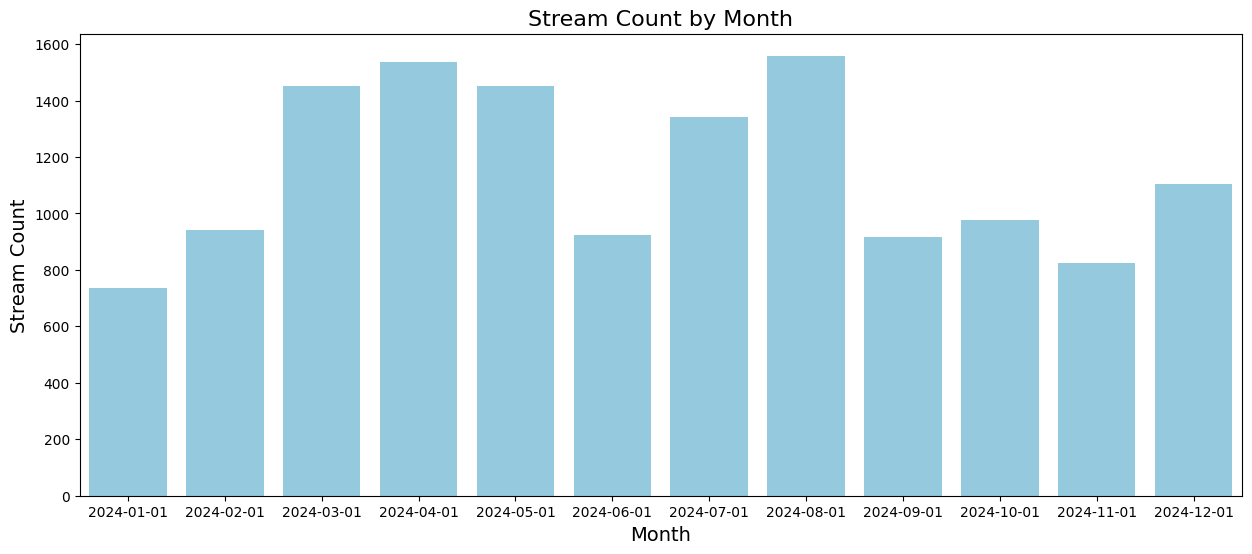

In [54]:
monthly_counts = df.groupby('first_day_of_month')['ts'].count().reset_index()
monthly_counts.rename(columns={'ts': 'stream_count'}, inplace=True)

plt.figure(figsize=(15,6))
sns.barplot(data=monthly_counts, x='first_day_of_month', y='stream_count', color='skyblue')

plt.title("Stream Count by Month", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Stream Count", fontsize=14)
plt.show()


My streaming frequency changes by month - I have 2 peaks - in spring (Mar to May) and summer (Jul to Aug). I tended to be "lazier" in autumn and winter isn't it!

Based on this observation and common sense about seasons, here is how I broke down the months into seasons.



In [55]:
#Based on the view above, I create the month groups as followed:

df['month'] = df['ts'].dt.month

# Map months into groups
def month_group(m):
    if 3 <= m <= 5:
        return "1. Spring"
    elif 5 <= m <= 8:
        return "2. Summer"
    elif 9 <= m <= 11:
        return "3. Autumn"
    else:
        return "4. Winter"

df['season'] = df['month'].apply(month_group)

## Audio Characteristics

I'll review the differences in audio features between time of the day and months of the year.

In [56]:
feature_cols = df_track.columns[3:]  
df_merged = df.merge(df_track, on='track_id', how='inner')

def create_boxplot(x_column):
    n = len(feature_cols)-1
    rows, cols = 4, 3 

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows), sharey=False)
    axes = axes.ravel()

    for ax, feature in zip(axes, feature_cols):
        sns.boxplot(
            data=df_merged,
            x=x_column,
            y=feature,
            ax=ax,
            palette="Blues",
            showfliers=False,
            order = sorted(df_merged[x_column].unique())
        )
        ax.set_title(feature.capitalize())
        ax.set_xlabel("")
        ax.set_ylabel("")

    for ax in axes[len(feature_cols):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


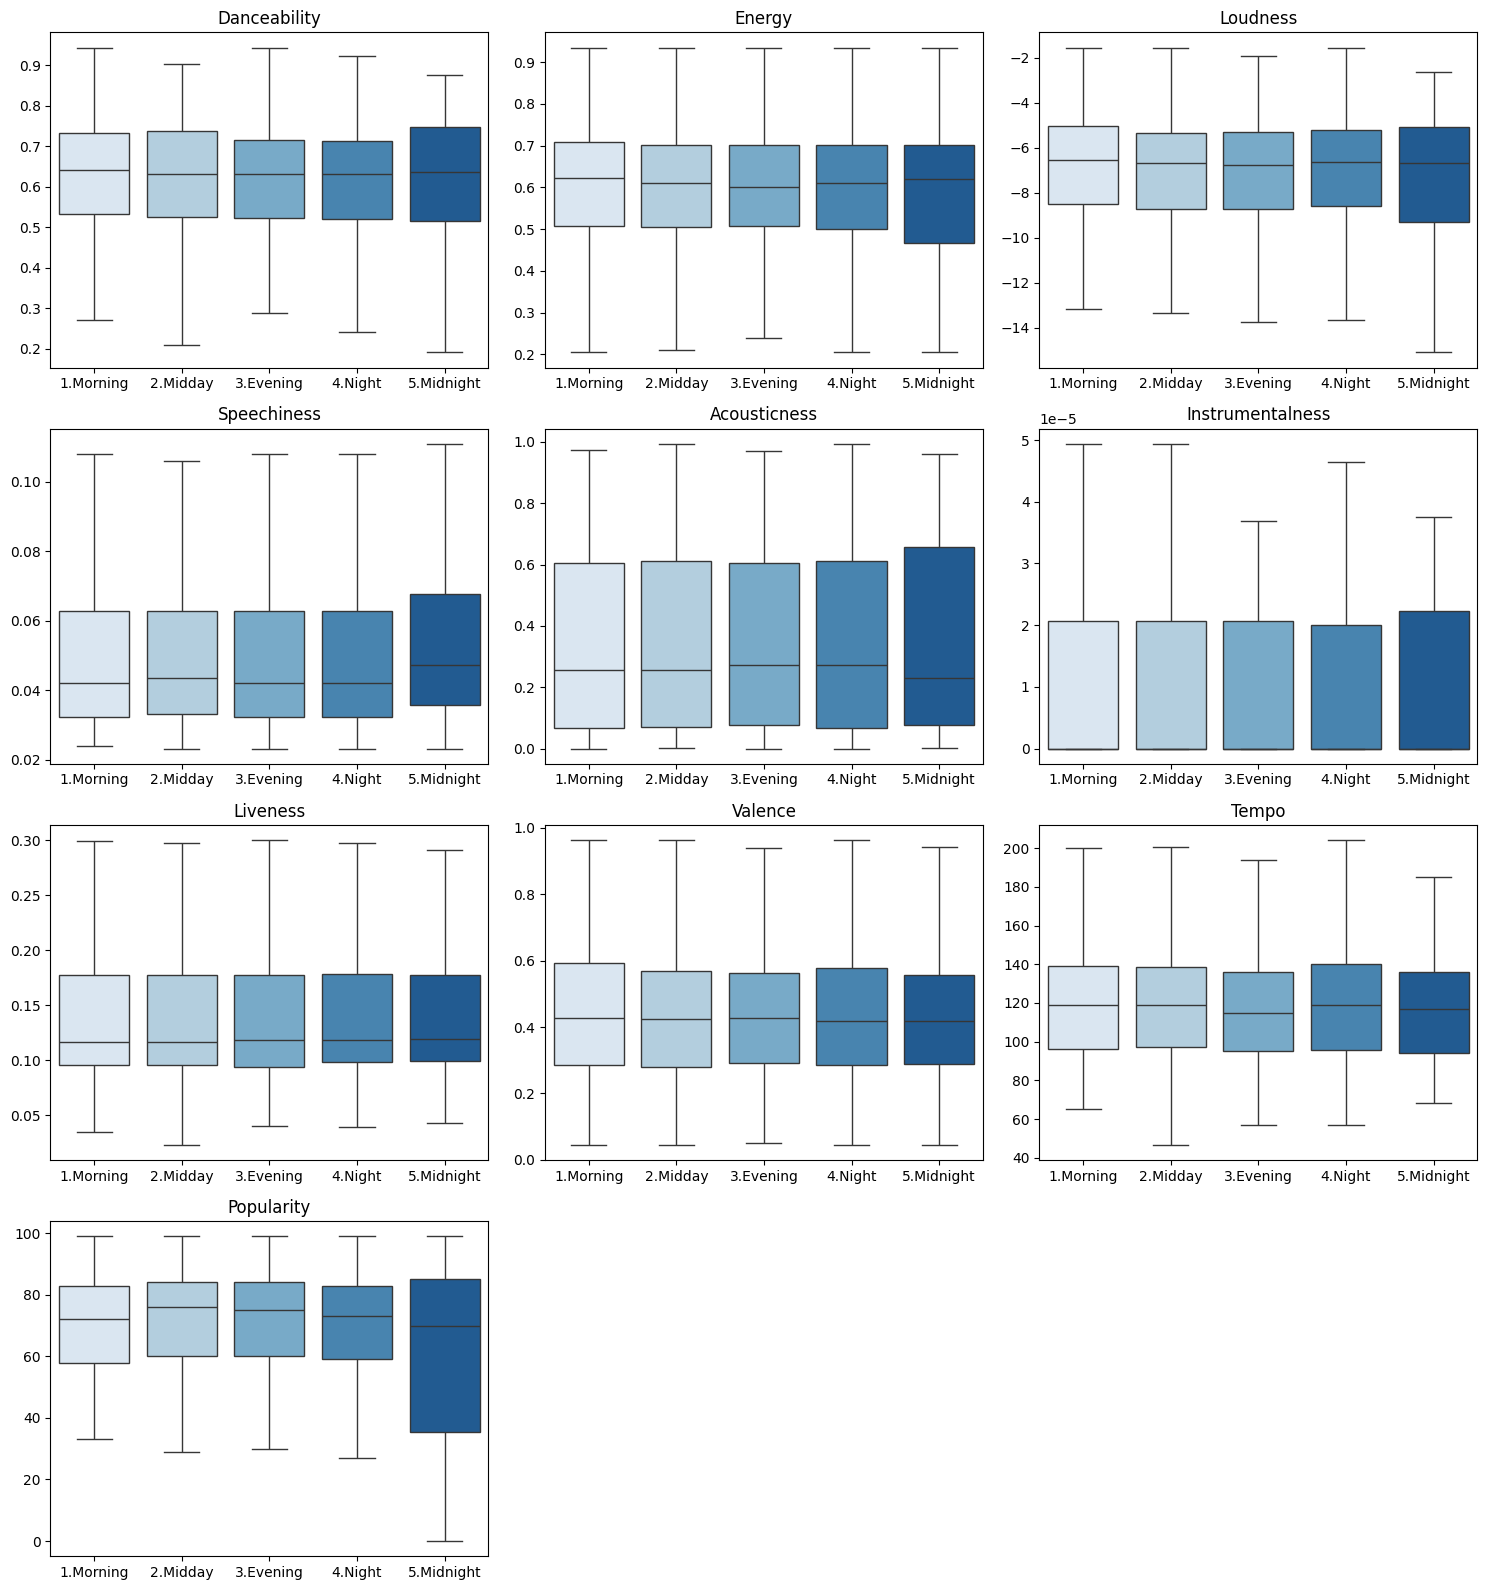

In [57]:
create_boxplot("time_of_day")

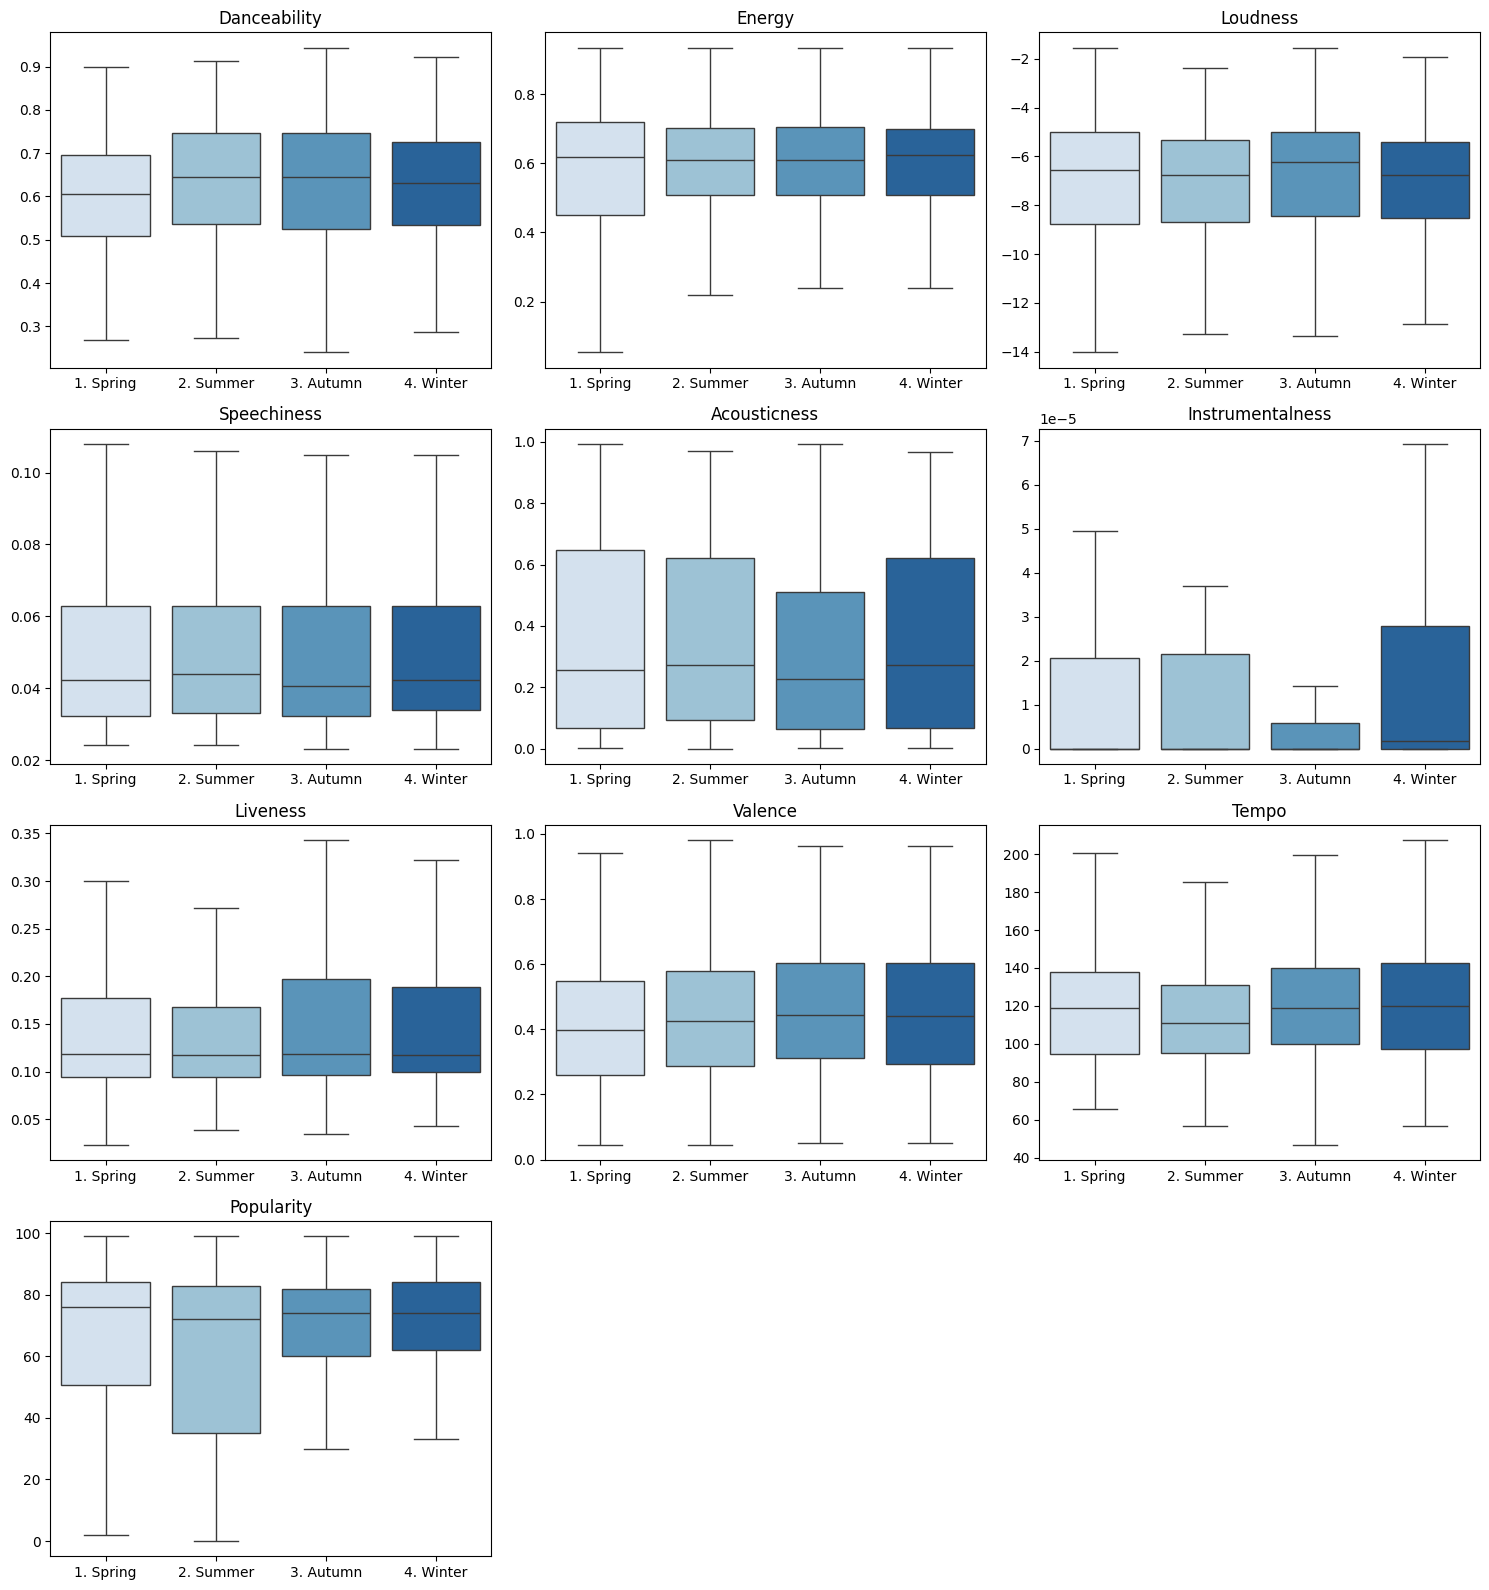

In [58]:
create_boxplot("season")

To understand these charts, first, let's review the definition of each audio feature:
- **danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable

- **energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale

- **loudness**: The overall loudness of a track in decibels (dB)

- **speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks

- **acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic

- **instrumentalness**: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content

- **liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live

- **valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)

- **tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration

- **popularity**: The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity.

There are more differences between seasons:
- Spring time: less danceable, energetic music! 
- Summer time: time to explore more unpopular tracks
- Autumn: less instrumentalness, more vocal
- Winter: most instrumental 


# Recommendation System

In [59]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


## Define the rules

Some rules for my recommendation systems:
1. **Time-of-day personalization**: I prefer not to listen to the same music throughout the day, so recommendations will be tailored for different parts of the day.

2. **Seasonal preferences**: My taste and music popularity vary by season, so recommendations will also adapt to each season of the year.

3. **Familiar artists**: I tend to be conservative, preferring artists I’ve listened to before. Besides audio features, the system will include artist information with a weight of 0.3.

4. **Exploring new artists**: To discover less frequent artists, the system may exclude artists I listen to very often.

## Build the systems

In [60]:
# 1. Merge streams with track features
df_merged = df.merge(df_track, on='track_id', how='inner')


# 2. Deduplicate tracks & Filter the tracks belong to my list of artists
df_track_unique = df_track.drop_duplicates(subset=['track_id']).reset_index(drop=True)


valid_artists = df['master_metadata_album_artist_name'].unique()
df_track_unique = df_track_unique[
    df_track_unique['track_artist'].isin(valid_artists)
].reset_index(drop=True)


# 3. One-hot encode artists
encoder = OneHotEncoder(sparse_output=False)  
artist_embeddings = encoder.fit_transform(df_track_unique[['track_artist']]).astype('float32')


# 4. Prepare track embeddings (audio + artist)
alpha = 0.7  # weight for audio features
beta = 0.3   # weight for artist features

audio_embeddings = df_track_unique[feature_cols].to_numpy().astype('float32')
track_embeddings = np.hstack([alpha * audio_embeddings, beta * artist_embeddings]).astype('float32')
track_embeddings /= np.linalg.norm(track_embeddings, axis=1, keepdims=True)


# 5. Build NearestNeighbors model

track_embeddings_clean = np.nan_to_num(track_embeddings, nan=0.0)

# Fit KNN model
knn_model = NearestNeighbors(n_neighbors=100, metric="cosine")
knn_model.fit(track_embeddings_clean)


# 6. Build user profiles (season + time_of_day)

# Audio profile per (season, time_of_day)
profiles_audio = (
    df_merged.groupby(['season', 'time_of_day'])[feature_cols]
    .mean()
    .apply(lambda x: x / np.linalg.norm(x), axis=1)
)

# Artist profile per (season, time_of_day)
profiles_artist = (
    df_merged.groupby(['season','time_of_day','track_artist'])['track_id']
    .count()
    .groupby(level=[0,1])
    .apply(lambda x: x / x.sum())
    .unstack(fill_value=0)
    .astype('float32')
)

# Align columns with encoder
profiles_artist = profiles_artist.reindex(columns=encoder.categories_[0], fill_value=0)


# 8. Recommendation function
def recommend_for_context(season, time_segment, k=5, exclude_artists=None):
    if exclude_artists is None:
        exclude_artists = []
    exclude_set = set(exclude_artists)

    if ((season, time_segment) not in profiles_audio.index) or ((season, time_segment) not in profiles_artist.index):
        return pd.DataFrame(columns=['track_id', 'similarity'])

    # Build user profile
    audio_profile = profiles_audio.loc[(season, time_segment)].to_numpy().astype('float32').reshape(1, -1)
    artist_profile = profiles_artist.loc[(season, time_segment)].to_numpy().astype('float32').reshape(1, -1)
    user_profile = np.hstack([alpha * audio_profile, beta * artist_profile])
    user_profile /= np.linalg.norm(user_profile, axis=1, keepdims=True)

    # KNN search
    distances, indices = knn_model.kneighbors(user_profile, n_neighbors=k+100)
    candidates = df_track_unique.iloc[indices[0]].copy()
    candidates['similarity'] = 1 - distances[0]

    # Keep only listened artists, excluding top artists
    listened_artists = set(df_merged[
        (df_merged['season'] == season) & (df_merged['time_of_day'] == time_segment)
    ]['track_artist'])
    valid_artists = listened_artists - exclude_set
    recs = candidates[candidates['track_artist'].isin(valid_artists)]

    # Drop duplicates and return top-k
    recs_final = recs.drop_duplicates(subset=['track_name','track_artist']).head(k)
    recs_final['season'] = season
    recs_final['time_of_day'] = time_segment

    return recs_final


# 9. Get top 20 most frequent artists
top_20_artists = (
    df_merged.groupby('master_metadata_album_artist_name')
             .agg(count=('ts', 'count'))
             .reset_index()
             .sort_values(by='count', ascending=False)
             .head(20)
)['master_metadata_album_artist_name'].unique()

# 10. Generate recommendations for all contexts
recommendations_list = []
for season in sorted(df['season'].unique()):
    for time_segment in sorted(df['time_of_day'].unique()):
        recs = recommend_for_context(season, time_segment, k=5, exclude_artists=top_20_artists)
        recommendations_list.append(recs[['season','time_of_day','track_name','track_artist','similarity']])

recommendations_table = pd.concat(recommendations_list, ignore_index=True)


## Test it out!

I want it to be a little interactive, so I will use widget library from Python to let me pick the specific time and season!

In [61]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Dropdowns for season and time_of_day
season_dropdown = widgets.Dropdown(
    options=sorted(df['season'].unique()),
    description="Season:",
    style={'description_width': 'initial'}
)

time_dropdown = widgets.Dropdown(
    options=sorted(df['time_of_day'].unique()),
    description="Time of Day:",
    style={'description_width': 'initial'}
)

output = widgets.Output()

# Function to run recommender on selection
def on_select(change=None):
    with output:
        clear_output()
        season = season_dropdown.value
        time_segment = time_dropdown.value
        recs = recommend_for_context(season, time_segment, k=5, exclude_artists=top_20_artists)
        if recs.empty:
            print(f"No recommendations found for {season} - {time_segment}")
        else:
            display(recs[['season','time_of_day','track_name','track_artist','similarity']])

# Attach handler
season_dropdown.observe(on_select, names="value")
time_dropdown.observe(on_select, names="value")

# Show
display(season_dropdown, time_dropdown, output)
on_select()


Dropdown(description='Season:', options=('1. Spring', '2. Summer', '3. Autumn', '4. Winter'), style=Descriptio…

Dropdown(description='Time of Day:', options=('1.Morning', '2.Midday', '3.Evening', '4.Night', '5.Midnight'), …

Output()

Now it's an autumn morning. Let's chill and enjoy some music with me: [嚣张 by en](https://open.spotify.com/track/1vfUASvUGt3gxQ1x3T3u1C?si=b3f417d9075e40cf)